## CRISP-DM (https://www.datascience-pm.com/crisp-dm-2/)

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
- 4. Modeling
- 5. Evaluation
- 6. Deployment

### 1. Business Understanding

- 1.1. Determine business objectives
- 1.2. Assess situation
- 1.3. Determine data mining goals
- 1.4. Produce project plan

Isto deve ser so teorico

### 2. Data Understanding

- 2.1. Collect initial data - ler os dados todos
- 2.2. Describe data - examinar os dados e descreve-los, as suas propriedades, numero de ocorrencia, etc.
- 2.3. Explore data - explorar os dados, visualizalos, ver padroes, etc.
- 2.4. Verify data quality - verificar a integridade dos dados, ver se tem erros, inconsistencias, etc.

In [8]:
										#-----------------------------#
										#    2. DATA UNDERSTANDING    #
										#-----------------------------#

import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.

'''
datasetL = [] # dataset por linha, pode ser util

with open('dataset.csv', mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        datasetL.append(lines)

categorias = datasetL[0]
datasetL.pop(0)
datasetL = np.array(datasetL)
'''

with open('dataset.csv', mode ='r')as file:
	csvFile = csv.reader(file)
	categorias = next(csvFile)

dadosC = pd.read_csv("dataset.csv")
datasetC = [] # dataset por coluna

for i in categorias:
    datasetC.append(dadosC[i].tolist())

datasetC = np.array(datasetC)

# 2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.

# exemplos do dataset
'''
for i in range(len(categorias)):
    print("Categoria "+str(categorias[i])+":")
    print(datasetC[i,0:5],end="\n\n")
'''

# tipos de diferentes respostas a cada categoria
for i in range(len(categorias)):
    print("Tipos de respostas para a categoria "+str(categorias[i])+":")
    print(np.unique(datasetC[i]),end="\n\n")



# graficos para respostas
'''
count = 0
for i in datasetC:
	unicos = np.unique(i)
	valores = [np.count_nonzero(i==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(count)+" Respostas sobre a categoria "+str(categorias[count]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()
	count+=1 
'''

# pessoas que dizem que n fazem exercicio -> +% na parte de doencas
'''
indices = []
for i in range(len(datasetC[2])):
    #3 4 5 6 7 8
    if datasetC[2][i] == "No":
        indices.append(i)

for i in range(3,9):
	unicos = np.unique(datasetC[i])
	valores = [str(datasetC[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que nao fazem exercicio para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''


# ver que respostas deram as pessoas que tem problemas cardiacos
'''
indices = []
for i in range(len(datasetC[3])):
    if datasetC[3][i] == "Yes":
        indices.append(i)

for i in range(len(categorias)):
	unicos = np.unique(datasetC[i])
	valores = [str(datasetC[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que têm doenças cardiacas para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''

# 2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.

# falar da inconsistencia das batatas fritas / alcool / fruta / vegetais
# vou usar quantas vezes por mes come/bete a categoria

# mostrar que nao tem valores em falta
'''
for i in datasetC:
    print(len(i))
print(len(datasetL))
'''

Tipos de respostas para a categoria General_Health:
['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']

Tipos de respostas para a categoria Checkup:
['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']

Tipos de respostas para a categoria Exercise:
['No' 'Yes']

Tipos de respostas para a categoria Heart_Disease:
['No' 'Yes']

Tipos de respostas para a categoria Skin_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Other_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Depression:
['No' 'Yes']

Tipos de respostas para a categoria Diabetes:
['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']

Tipos de respostas para a categoria Arthritis:
['No' 'Yes']

Tipos de respostas para a categoria Sex:
['Female' 'Male']

Tipos de respostas para a categoria Age_Category:
['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']

Tipos d

'\nfor i in datasetC:\n    print(len(i))\nprint(len(datasetL))\n'

### 3. Data Preparation

- 3.1. Select data - Determine which data sets will be used and document reasons for inclusion/exclusion.
- 3.2. Clean data - Often this is the lengthiest task. Without it, you’ll likely fall victim to garbage-in, garbage-out. A common practice during this task is to correct, impute, or remove erroneous values.
- 3.3. Construct data - Derive new attributes that will be helpful. For example, derive someone’s body mass index from height and weight fields.
- 3.4. Integrate data - Create new data sets by combining data from multiple sources.
- 3.5. Format data - Re-format data as necessary. For example, you might convert string values that store numbers to numeric values so that you can perform mathematical operations.

Esta parte vai ser para a parte de alterar o dataset que o stor disse, depois temos de incluir estes topicos talvez

###### - Randomly remove 10% and 20% of the values of the features the dataset and explore two different strategies to handle missing values;
###### - Experiment with data normalization, data discretization, and data reduction. Apply these steps to the original, unchanged, dataset.

Nones testes[0] 55886
len() testes[0] 308854
Nones testes2[0] 0
len() testes2[0] 308854
['150-160', '161-170', '161-170', '171-180', '191-200', '181-190', '171-180', '161-170', '161-170', '161-170', '150-160', '171-180', '161-170', '171-180', '150-160', '161-170', '161-170', '161-170', '171-180', '161-170', '150-160', '171-180', '171-180', '161-170', '161-170', '150-160', '150-160', '150-160', '161-170', '171-180', '161-170', '161-170', '181-190', '150-160', '181-190', '161-170', '161-170', '161-170', '161-170', '161-170', '150-160', '171-180', '161-170', '161-170', '161-170', '171-180', '161-170', '161-170', '161-170', '150-160']
308854
['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']
[45947, 29354, 78045, 9291, 146217]


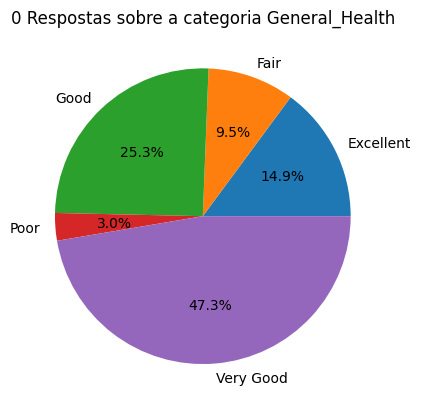

['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']
[10992, 1170, 30490, 14269, 251933]


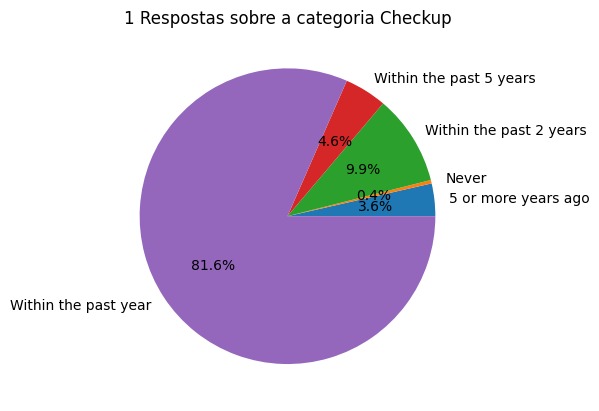

['No' 'Yes']
[56813, 252041]


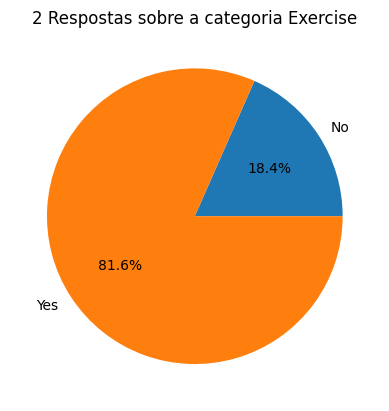

['No' 'Yes']
[288480, 20374]


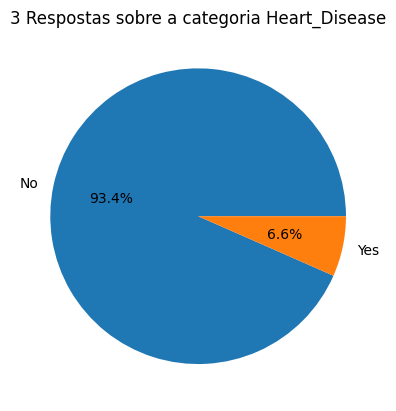

['No' 'Yes']
[284324, 24530]


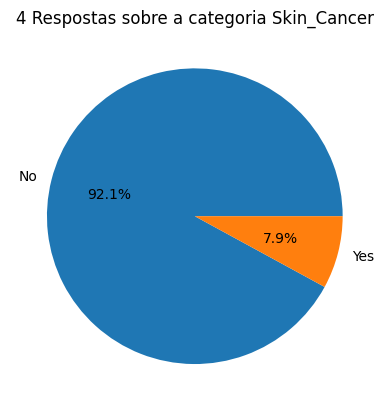

['No' 'Yes']
[284426, 24428]


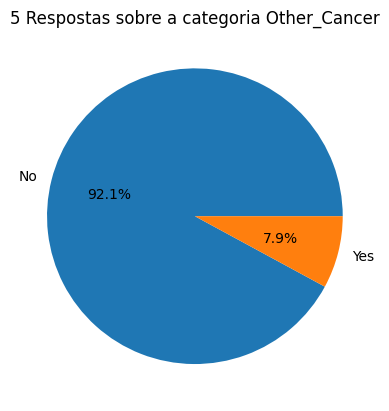

['No' 'Yes']
[258323, 50531]


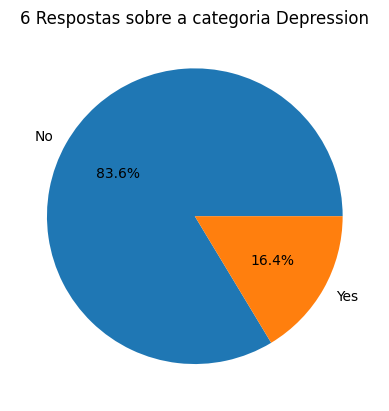

['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']
[268223, 5657, 32769, 2205]


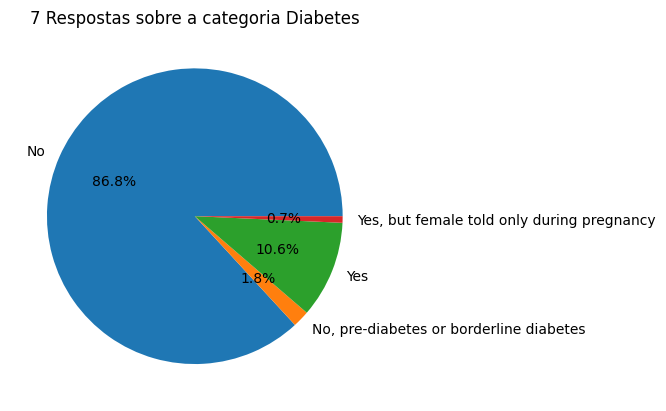

['No' 'Yes']
[225949, 82905]


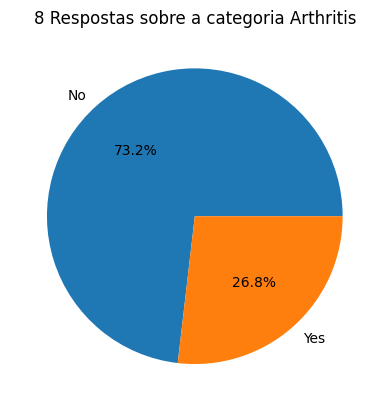

['Female' 'Male']
[187005, 121849]


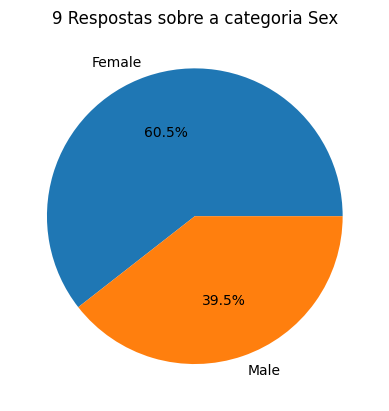

['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']
[15285, 12709, 15056, 16897, 17638, 17147, 20653, 22912, 26535, 83379, 25566, 16906, 18171]


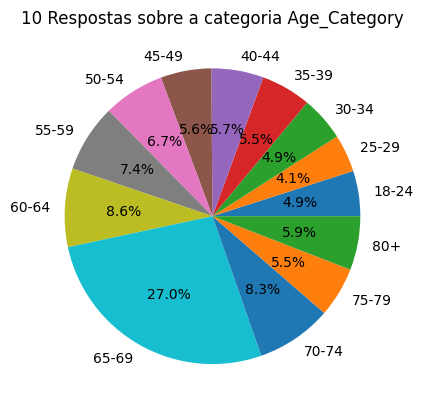

['150-160' '161-170' '171-180' '181-190' '191-200' '<150' '>200']
[51158, 139135, 73147, 34581, 8475, 1853, 505]


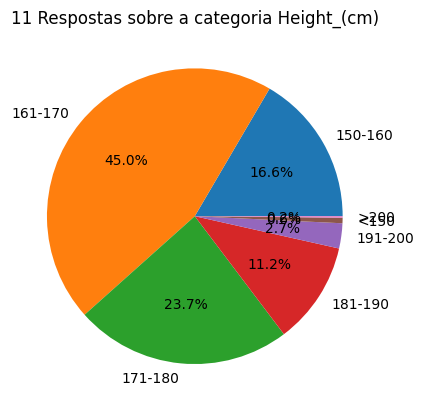

['101-120' '121-140' '40-60' '61-80' '81-100' '<40' '>140']
[31034, 11019, 28625, 93698, 140318, 237, 3923]


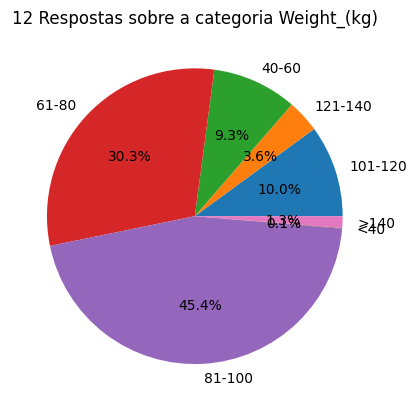

['gorda' 'magra' 'normal' 'obesa']
[20562, 20701, 264332, 3259]


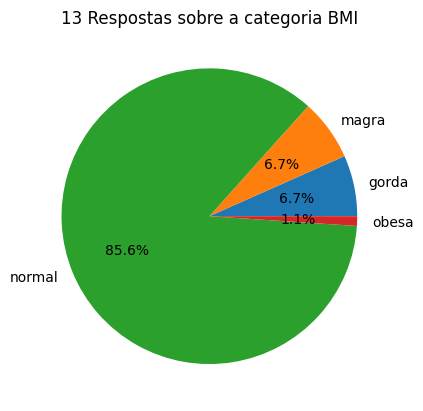

['No' 'Yes']
[206249, 102605]


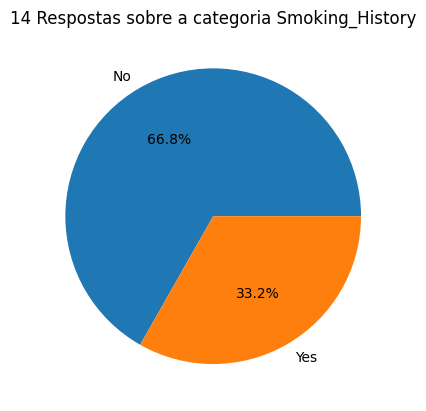

['bastante' 'medio' 'muito' 'nada' 'pouco']
[18738, 37792, 16481, 170549, 65294]


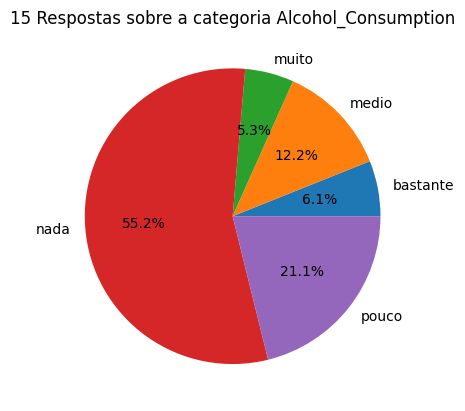

['bastante' 'medio' 'muito' 'muito pouco' 'nada' 'pouco']
[16444, 150504, 41731, 46992, 6786, 46397]


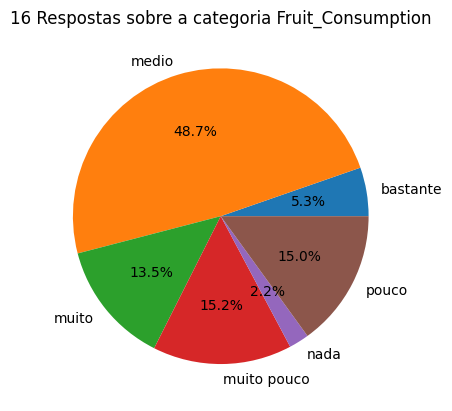

[' muito' 'medio' 'muito pouco' 'nada' 'pouco']
[10616, 121805, 93994, 17533, 64906]


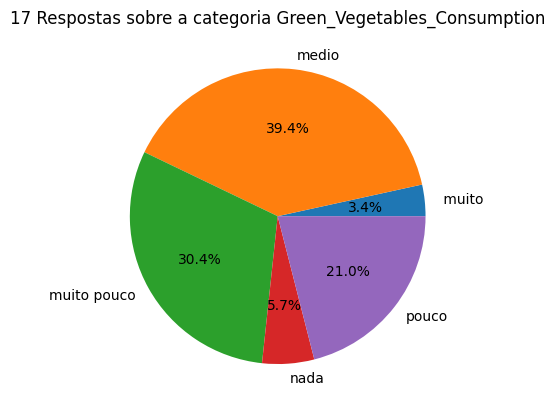

['bastante' 'medio' 'muito' 'nada' 'pouco']
[26485, 43743, 24304, 36176, 178146]


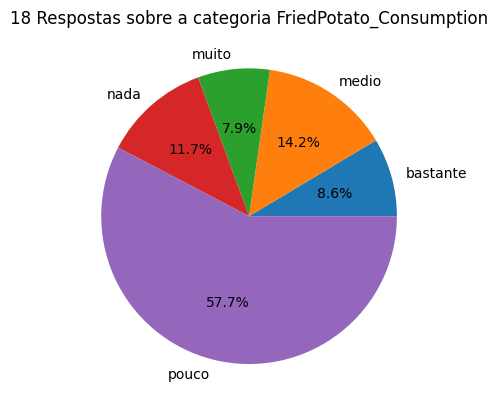

'\tPESO\na = datasetC[12]\nyerp = list(map(float, a.tolist()))\nyerp = np.array(yerp)\nyerp = np.sort(yerp)\n\nlabels = ["<40","40-60","61-80","81-100","101-120","121-140",">140"]\nvalores = [0,0,0,0,0,0,0]\nfor i in yerp:\n    if i < 40:\n        valores[0]+=1\n    elif i >= 40 and i <=60:\n        valores[1]+=1\n    elif i > 60 and i <=80:\n        valores[2]+=1\n    elif i > 80 and i <=100:\n        valores[3]+=1\n    elif i > 100 and i <=120:\n        valores[4]+=1\n    elif i > 120 and i <=140:\n        valores[5]+=1\n    else:\n        valores[6]+=1\n\n##############\nvatual = 0\nnicers = [0]\nva = []\nfor i in yerp:\n    if i % 20 == 0 and i > vatual:\n        nicers.append(i)\n        vatual = i\n        va.append(vatual)\n    nicers[-1] += 1\nprint(nicers)\nprint(va)\nnovo = [\'a\' for i in range(len(nicers))]\nfor i in range(len(nicers)):\n    if i == 0:\n        novo[i] = ">"+str(va[i])\n    elif i== len(nicers)-1:\n        novo[i] = "<"+str(va[i-1])\n    else:\n        novo

In [ ]:
										#-----------------------------#
										#     3. DATA PREPARATION     #
										#-----------------------------#

from collections import Counter

# REMOVER DADOS

# remove os dados do dataset dado com a percentagem dada
def remover_dados(percentagem,dataset):
    
	tamanho = 0
	for i in range(len(dataset)): # calcula tamanho do dataset
		tamanho += len(dataset[i])

	for i in range(int(tamanho*percentagem)):
		dataset[random.randint(0,len(dataset)-1)][random.randint(0,len(dataset[0])-1)] = None # elemento random

	return dataset

copia = datasetC.copy()

testes = remover_dados(0.2,copia)
ok = 0
for i in testes[0]:
	if i == "None":
		ok+=1
print("Nones testes[0] "+str(ok))
print("len() testes[0] "+str(len(testes[0])))


# Metodo 1 - apagar os dados

''' Apagar dados, melhorar depois
testes = testes.tolist()

for i in range(len(testes)):
	for j in range(len(testes[i])):
		if testes[i][j] == "None":
			for w in range(len(testes)):
				testes[w] = np.delete(testes[w],j)'''


# METODO 1, substituir pelo valor mais frequente

def mais_freq(dataset):
	dataset = dataset.tolist()
	maxx = []
	for i in range(len(dataset)): # VER O BMI
		conta = Counter(dataset[i])
		del conta["None"]
		#print(conta.most_common(1))
		maxx.append(conta.most_common(1))

	#print(maxx)
	#print(maxx[0])
	#print(maxx[0][0][0])

	for i in range(len(dataset)):
		for j in range(len(dataset[i])):
			if dataset[i][j] == "None":
				dataset[i][j] = maxx[i][0][0]

	
	return dataset

testes2 = mais_freq(testes)
ok2 = 0
for i in testes2[0]:
	if i == "None":
		ok2+=1
print("Nones testes2[0] "+str(ok2))
print("len() testes2[0] "+str(len(testes2[0])))

# METODO 2, jonnas






# data discretization-data discretization-data discretization-data discretization-data discretization


# as comidas e bebidas para - nada muito_pouco pouco medio muito bastante
# altura - >100, 100-110, 111-120, 121-130, 131-140, 141-150, 151-160, 161-170, 171-180, 181-190, 191-200, <200
# BMI -> muito magro, magro normal, gordo, obeso, obesidade morbida
# peso -> data['bins'] = pd.cut(data['values'], bins=5, labels=['Low', 'Medium', 'High'])

def data_discretization(datasetC):

	#ALTURA
	for i in range(len(datasetC[11])):
		if float(datasetC[11][i]) < 150:
			datasetC[11][i] = "<150"
		elif float(datasetC[11][i]) >= 150 and float(datasetC[11][i]) <=160:
			datasetC[11][i] = "150-160"
		elif float(datasetC[11][i]) > 160 and float(datasetC[11][i]) <=170:
			datasetC[11][i] = "161-170"
		elif float(datasetC[11][i]) > 170 and float(datasetC[11][i]) <=180:
			datasetC[11][i] = "171-180"
		elif float(datasetC[11][i]) > 180 and float(datasetC[11][i]) <=190:
			datasetC[11][i] = "181-190"
		elif float(datasetC[11][i]) > 190 and float(datasetC[11][i]) <=200:
			datasetC[11][i] = "191-200"
		else:
			datasetC[11][i] = ">200"
	
	#PESO
	for i in range(len(datasetC[12])):
		if float(datasetC[12][i]) < 40:
			datasetC[12][i] = "<40"
		elif float(datasetC[12][i]) >= 40 and float(datasetC[12][i]) <=60:
			datasetC[12][i] = "40-60"
		elif float(datasetC[12][i]) > 60 and float(datasetC[12][i]) <=80:
			datasetC[12][i] = "61-80"
		elif float(datasetC[12][i]) > 80 and float(datasetC[12][i]) <=100:
			datasetC[12][i] = "81-100"
		elif float(datasetC[12][i]) > 100 and float(datasetC[12][i]) <=120:
			datasetC[12][i] = "101-120"
		elif float(datasetC[12][i]) > 120 and float(datasetC[12][i]) <=140:
			datasetC[12][i] = "121-140"
		else:
			datasetC[12][i] = ">140"

	#BMI
	for i in range(len(datasetC[13])):
		bmi = 10 + (float(datasetC[13][i]) / 100) * (50-10)
		if bmi < 18.5:
			datasetC[13][i] = "magra"
		elif bmi >= 18.5 and bmi <= 24.9:
			datasetC[13][i] = "normal"
		elif bmi >= 25 and bmi <= 29.9:
			datasetC[13][i] = "gorda"
		else:
			datasetC[13][i] = "obesa"
		
	#ALCOOL
	for i in range(len(datasetC[15])):
		if float(datasetC[15][i]) == 0: # 0 - nada
			datasetC[15][i] = "nada"
		elif float(datasetC[15][i])>0 and float(datasetC[15][i]) <= 4: # 1x por semana - pouco
			datasetC[15][i] = "pouco"
		elif float(datasetC[15][i])>4 and float(datasetC[15][i]) <=12: #2/3x por semana - medio
			datasetC[15][i] = "medio"
		elif float(datasetC[15][i]) > 12 and float(datasetC[15][i]) <= 20: # 4/5x por semana - muito
			datasetC[15][i] = "muito"
		else: # +5x por semana - bastante
			datasetC[15][i] = "bastante"

	#FRUTA
	for i in range(len(datasetC[16])):
		if float(datasetC[16][i]) == 0: # 0 - nada
			datasetC[16][i] = "nada"
		elif float(datasetC[16][i]) >0 and float(datasetC[16][i]) <9: # 1/2x por semana - muito pouco
			datasetC[16][i] = "muito pouco"
		elif float(datasetC[16][i]) >=9 and float(datasetC[16][i]) <17: # 3/4x por semana - pouco
			datasetC[16][i] = "pouco"
		elif float(datasetC[16][i]) >=17 and float(datasetC[16][i]) <31: # 5x por semana a 1x por dia - medio
			datasetC[16][i] = "medio"
		elif float(datasetC[16][i]) >=31 and float(datasetC[16][i]) <61: # 1/2x por dia - muito
			datasetC[16][i] = "muito"
		else: # +2x por dia - bastante
			datasetC[16][i] = "bastante"

	#VEGETAIS
	for i in range(len(datasetC[17])):
		if float(datasetC[17][i]) == 0: # 0 nada
			datasetC[17][i] = "nada"
		elif float(datasetC[17][i]) >0 and float(datasetC[17][i]) <9: # 1/2x por semana - muito pouco
			datasetC[17][i] ="muito pouco"
		elif float(datasetC[17][i]) >=9 and float(datasetC[17][i]) <17: # 3/4x por semana - pouco
			datasetC[17][i] = "pouco"
		elif float(datasetC[17][i]) >=17 and float(datasetC[17][i]) <31: # 5x por semana a 1x por dia - medio
			datasetC[17][i] = "medio"
		else: # +1x por dia - muito
			datasetC[17][i] = " muito"

	#BATATA FRITA
	for i in range(len(datasetC[18])):
		if float(datasetC[18][i]) == 0: # 0 - nada
			datasetC[18][i] = "nada"
		elif float(datasetC[18][i])> 0 and float(datasetC[18][i]) <5: #1x por semana - pouco
			datasetC[18][i] = "pouco"
		elif float(datasetC[18][i]) >=5 and float(datasetC[18][i]) <9: # 2x por semana - medio
			datasetC[18][i] = "medio"
		elif float(datasetC[18][i]) >=9 and float(datasetC[18][i]) <13: # 3x por semana - muito
			datasetC[18][i] = "muito"
		else: # +3x por semana - bastante
			datasetC[18][i] = "bastante"

	return datasetC

#copia2 = datasetC.copy()

testes3 = data_discretization(testes2)

print(testes3[11][0:50])
print(len(testes3[11]))

testes3 = np.array(testes3)

for i in [11,12,13,15,16,17,18]:
	unicos = np.unique(testes3[i])
	valores = [np.count_nonzero(testes3[i]==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(i)+" Novas respostas sobre a categoria "+str(categorias[i]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()


# com graficos \/


'''ALCOOL
a = datasetC[15]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)
print(np.unique(yerp))

labels=["nada", "pouco", "medio" ,"muito", "bastante"]
valores=[0,0,0,0,0]

for i in yerp:
    if i == 0: # 0 - nada
        valores[0]+=1
    elif i>0 and i <= 4: # 1x por semana - pouco
        valores[1]+=1
    elif i>4 and i <=12: #2/3x por semana - medio
        valores[2]+=1
    elif i > 12 and i <= 20: # 4/5x por semana - muito
          valores[3]+=1
    elif i> 20: # +5x por semana - bastante
        valores[4]+=1

plt.title("Respostas sobre a categoria "+str(categorias[15]))
plt.pie(valores,labels=labels,autopct='%1.1f%%')
plt.show()
'''

'''BATATA FRITA
a = datasetC[18]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)
print(np.unique(yerp))

labels=["nada", "pouco", "medio" ,"muito", "bastante"]
valores = [0,0,0,0,0]

for i in yerp:
    if i == 0: # 0 - nada
        valores[0] +=1
    elif i> 0 and i <5: #1x por semana - pouco
        valores[1]+=1
    elif i >=5 and i <9: # 2x por semana - medio
        valores[2]+=1
    elif i >=9 and i <13: # 3x por semana - muito
        valores[3]+=1
    else: # +3x por semana - bastante
        valores[4]+=1

print(valores)

plt.title("Respostas sobre a categoria "+str(categorias[18]))
plt.pie(valores,labels=labels,autopct='%1.1f%%')
plt.show()
'''

'''VEGETAIS
a = datasetC[17]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)
print(np.unique(yerp))

labels=["nada","muito_pouco", "pouco", "medio" ,"muito"]
valores = [0,0,0,0,0]

for i in yerp:
    if i == 0: # 0 nada
        valores[0] +=1
    elif i >0 and i <9: # 1/2x por semana - muito pouco
        valores[1]+=1
    elif i >=9 and i <17: # 3/4x por semana - pouco
        valores[2]+=1
    elif i >=17 and i <31: # 5/6x por semana - medio
        valores[3]+=1
    else: # +1x por dia - muito
        valores[4]+=1

print(valores)

plt.title("Respostas sobre a categoria "+str(categorias[17]))
plt.pie(valores,labels=labels,autopct='%1.1f%%')
plt.show()
'''

'''FRUTA
a = datasetC[16]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)
print(np.unique(yerp))

labels=["nada","muito_pouco", "pouco", "medio" ,"muito", "bastante"]
valores = [0,0,0,0,0,0]

for i in yerp:
    if i == 0: # 0 - nada
        valores[0] +=1
    elif i >0 and i <9: # 1/2x por semana - muito pouco
        valores[1]+=1
    elif i >=9 and i <17: # 2/3x por semana - pouco
        valores[2]+=1
    elif i >=17 and i <31: # 4x por semana a 1x por dia - medio
        valores[3]+=1
    elif i >=31 and i <61: # 1/2x por dia - muito
        valores[4]+=1
    else: # +2x por dia - bastante
        valores[5]+=1
print(valores)

plt.title("Respostas sobre a categoria "+str(categorias[16]))
plt.pie(valores,labels=labels,autopct='%1.1f%%')
plt.show()
'''

'''ALTURA
a = datasetC[11]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)

labels = ["<150","150-160","161-170","171-180","181-190","191-200","<200"]
valores = [0,0,0,0,0,0,0]
for i in yerp:
    if i < 150:
        valores[0]+=1
    elif i >= 150 and i <=160:
        valores[1]+=1
    elif i > 160 and i <=170:
        valores[2]+=1
    elif i > 170 and i <=180:
        valores[3]+=1
    elif i > 180 and i <=190:
        valores[4]+=1
    elif i > 190 and i <=200:
        valores[5]+=1
    else:
        valores[6]+=1


##############3
vatual = 0
nicers = [0]
va = []
for i in yerp:
    if i % 10 == 0 and i > vatual:
        nicers.append(i)
        vatual = i
        va.append(vatual)
    nicers[-1] += 1
print(nicers)
print(va)

novo = ['a' for i in range(len(nicers))]
for i in range(len(nicers)):
    if i == 0:
        novo[i] = ">"+str(va[i])
    elif i== len(nicers)-1:
        novo[i] = "<"+str(va[i-1])
    else:
        novo[i] = str(va[i-1]+1)+"-"+str(va[i])
print(novo)
####################


plt.title("Respostas sobre a categoria "+str(categorias[11]))
plt.pie(valores,labels=labels,autopct='%1.1f%%')
plt.show()
'''

''' BMI
a = datasetC[13]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)

bmi = 10 + (yerp / 100) * (50 - 10)

labelss = ["magra","normal","gorda","obesa"]
valores = np.array([0,0,0,0])

for i in bmi:
    if i < 18.5:
        valores[0] += 1
    elif i >= 18.5 and i <= 24.9:
        valores[1] +=1
    elif i >= 25 and i <= 29.9:
        valores[2] +=1
    else:
        valores[3]+=1

plt.title("Respostas sobre a categoria "+str(categorias[13]))
plt.pie(valores,labels=labelss,autopct='%1.1f%%')
plt.show()
'''

'''	PESO
a = datasetC[12]
yerp = list(map(float, a.tolist()))
yerp = np.array(yerp)
yerp = np.sort(yerp)

labels = ["<40","40-60","61-80","81-100","101-120","121-140",">140"]
valores = [0,0,0,0,0,0,0]
for i in yerp:
    if i < 40:
        valores[0]+=1
    elif i >= 40 and i <=60:
        valores[1]+=1
    elif i > 60 and i <=80:
        valores[2]+=1
    elif i > 80 and i <=100:
        valores[3]+=1
    elif i > 100 and i <=120:
        valores[4]+=1
    elif i > 120 and i <=140:
        valores[5]+=1
    else:
        valores[6]+=1

##############
vatual = 0
nicers = [0]
va = []
for i in yerp:
    if i % 20 == 0 and i > vatual:
        nicers.append(i)
        vatual = i
        va.append(vatual)
    nicers[-1] += 1
print(nicers)
print(va)
novo = ['a' for i in range(len(nicers))]
for i in range(len(nicers)):
    if i == 0:
        novo[i] = ">"+str(va[i])
    elif i== len(nicers)-1:
        novo[i] = "<"+str(va[i-1])
    else:
        novo[i] = str(va[i-1]+1)+"-"+str(va[i])
print(novo)
###########

plt.title("Respostas sobre a categoria "+str(categorias[12]))
plt.pie(valores,labels=labels,autopct='%1.1f%%')
plt.show()
'''



### 4. Modeling

- 4.1. Select modeling techniques - os algoritmos que o stor pede no enunciado
- 4.2. Generate test design - dependendo do modelo ter diferentes valores de sets de train, teste e validation
- 4.3. Build model - implementar os modelos
- 4.4. Assess model - interpretar os resultados dos modelos e comprara-los e testalos entre eles para ver qual/quais são os melhores

In [6]:
										#-----------------------------#
										#         4. Modeling         #
										#-----------------------------#

# Unsupervised Learning

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import pandas as pd

'''

ok = []
for i in range(len(datasetC)):
    if i != 3:
        ok.append(datasetC[i])
ok = np.array(ok)
coracao = datasetC[3]


dataset_transposed = ok.T # dataset sem coracao
dataset_numeric = []

for col in datasetC.T:
    try:
        # Try converting to float
        dataset_numeric.append(col.astype(float))
    except ValueError:
        # If it fails, encode categorical data
        le = LabelEncoder()
        encoded_col = le.fit_transform(col)
        dataset_numeric.append(encoded_col)

#dataset_numeric = np.array(dataset_numeric).T  # Transpose back to original shape

print("Numeric Dataset Sample:")
a = datasetC.T
print(len(a))
print(len(dataset_numeric))
print(a[2])
print(dataset_numeric[2])



#kmeans = KMeans(n_clusters=3, random_state=42)
#kmeans.fit(dataset_numeric)
#cluster_labels = kmeans.labels_

#print(kmeans.cluster_centers_)

'''

'''
# Combine clusters and target into a DataFrame for analysis
data_with_clusters = pd.DataFrame(dataset_numeric)
data_with_clusters['Cluster'] = cluster_labels
data_with_clusters['Heart Disease'] = coracao

# Group by cluster and compute statistics
cluster_summary = data_with_clusters.groupby('Cluster')['Heart Disease'].agg(['mean', 'count'])
print(cluster_summary)

feature_summary = data_with_clusters.groupby('Cluster').mean()
print(feature_summary)


# Apply k-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(datasetC.T)  # Transpose since sklearn expects samples as rows
labels_kmeans = kmeans.labels_

# Visualize k-Means clustering results (if reduced to 2D for visualization)
plt.scatter(datasetC[0], datasetC[1], c=labels_kmeans, cmap='viridis')
plt.title("k-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Print cluster centers
print("Cluster Centers (k-Means):")
print(kmeans.cluster_centers_)
'''

'\n# Combine clusters and target into a DataFrame for analysis\ndata_with_clusters = pd.DataFrame(dataset_numeric)\ndata_with_clusters[\'Cluster\'] = cluster_labels\ndata_with_clusters[\'Heart Disease\'] = coracao\n\n# Group by cluster and compute statistics\ncluster_summary = data_with_clusters.groupby(\'Cluster\')[\'Heart Disease\'].agg([\'mean\', \'count\'])\nprint(cluster_summary)\n\nfeature_summary = data_with_clusters.groupby(\'Cluster\').mean()\nprint(feature_summary)\n\n\n# Apply k-Means clustering\nkmeans = KMeans(n_clusters=3, random_state=42)\nkmeans.fit(datasetC.T)  # Transpose since sklearn expects samples as rows\nlabels_kmeans = kmeans.labels_\n\n# Visualize k-Means clustering results (if reduced to 2D for visualization)\nplt.scatter(datasetC[0], datasetC[1], c=labels_kmeans, cmap=\'viridis\')\nplt.title("k-Means Clustering")\nplt.xlabel("Feature 1")\nplt.ylabel("Feature 2")\nplt.show()\n\n# Print cluster centers\nprint("Cluster Centers (k-Means):")\nprint(kmeans.cluster

### 5. Evaluation

- 5.1. Evaluate results - ver que modelos devemos usar e quais melhor correspondem com o business criteria
- 5.2. Review process - fazer uma revisão critica ao trabalho feito
- 5.3. Determine next steps - determnar se esta bom para o deploymente, se é preciso melhorar um pouco mais ou expandir o projeto // ns bem como fazer isto neste trabalho

In [7]:
										#-----------------------------#
										#        5. Evaluation        #
										#-----------------------------#



### 6. Deployment

- 6.1. Plan deployment - desenvolver e documentar um plano para o deplyment
- 6.2. Plan monitoring and maintenance - Develop a thorough monitoring and maintenance plan to avoid issues during the operational phase (or post-project phase) of a model
- 6.3. Produce final report - The project team documents a summary of the project which might include a final presentation of data mining results.
- 6.4. Review project - Conduct a project retrospective about what went well, what could have been better, and how to improve in the future.

Ns o que fazer com esta parte